In [13]:
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv("synthetic_encoded_dataset.csv")
df.shape

(79844, 14)

In [15]:
from sklearn.model_selection import train_test_split

y = df.y.to_frame()
X = df.drop(columns = ["y"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
ids = np.arange(0, df.shape[0])
df["ClientID"] = ids
df.head()
df.shape

(79844, 15)

In [17]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = X
    data["y"] = y
    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def build_model(X, y):
    rf = KNeighborsClassifier()
    rf.fit(X, y)
    return rf


In [19]:
def test_global_model(X_test, y_test, local_models):
  y_predrf = np.zeros(y_test.shape[0])

  for model in local_models:
    y_predrf_local_model = model.predict(X_test)
    y_predrf = np.add(y_predrf, y_predrf_local_model)

  y_predrf = pd.DataFrame(y_predrf, columns=['y'])

  n = len(local_models)//2 + 1

  y_predrf.loc[(y_predrf.y <n), "y"] = 0
  y_predrf.loc[(y_predrf.y >=n), "y"] = 1
  accrf = accuracy_score(y_test, y_predrf)
  return accrf

  

In [20]:
def create_local_models(c):
  m = []
  c_names = list(c.keys())

  for c_name in c_names:
    df = c[c_name]
    y = df.y.to_frame()
    X = df.drop(columns = ["y"])
    local_model = build_model(X, y)
    m.append(local_model)
  return m

In [21]:
n = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
acc = []

for i in n:
  clients = create_clients(X_train, y_train, num_clients=i, initial='client')
  models = create_local_models(clients)
  acc_clients = test_global_model(X_test, y_test, models)
  acc.append(acc_clients*100)
n, acc

([3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31],
 [76.11772072636192,
  71.32122730118972,
  67.06324358171571,
  65.37257357545397,
  64.19536631183469,
  63.331246086412015,
  63.63180964308077,
  63.368816530995616,
  62.56731371321227,
  61.07701941139637,
  61.32748904195366,
  61.46524733876018,
  61.365059486537255,
  61.340012523481526,
  60.601127113337505])

In [10]:
acc_3 = [85.76, 79.04, 75.2, 73.11,71.86,71.48,70.61,70.07,69.37,65.94,64.01,63.48,63.81,63.43,63.01]

In [10]:
def build_model_rf(X, y):
    rf = RandomForestClassifier()
    rf.fit(X, y)
    return rf

In [13]:
n = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
acc_rf = []

for i in n:
  clients = create_clients(X_train, y_train, num_clients=i, initial='client')
  models = create_local_models(clients)
  acc_clients = test_global_model(X_test, y_test, models)
  acc_rf.append(acc_clients*100)
n, acc_rf

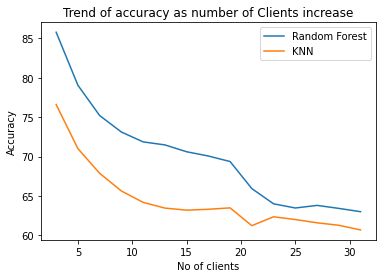

In [12]:
plt.plot(n, acc_3, linestyle = '-')
plt.plot(n, acc, linestyle = '-')
plt.xlabel('No of clients')
plt.ylabel('Accuracy')
plt.title('Trend of accuracy as number of Clients increase')
plt.legend(['Random Forest', 'KNN'])
plt.show()